In [64]:
import csv
import requests
import os
import re
import pandas as pd
from urllib.request import urlopen


# Dataset 1

## Weather data dataframe

### Creating one dataset

In [2]:
#create a list of all station names

stations_list = open("stations.txt", "r").readlines()
stations = []

for i in range(len(stations_list)):
    stations.append(stations_list[i].strip('\n'))

In [3]:
#This code fetches files from the Metoffice website
#this block should be run when new data needs to be fetched

#filenames = []

#for station in stations:
    #url= "http://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/" + station + 'data.txt'
    #r = requests.get(url, allow_redirects=True)
    #open(station+'.txt', 'wb').write(r.content)
    #filenames.append(station+'.txt')

In [4]:
#this block should be run when the data is available and does not need to be refreshed

filenames = []

for station in stations:
    file_name = station + '.txt'
    filenames.append(file_name)



In [5]:
#this loop creates one dataframe with all weather data from all stations

stations_data = []
col_names = ['yyyy','mm','tmax degC','tmin degC', 'af days', 'rain mm', 'sun hours', 'notes','notes2','notes3','notes4']

for file in filenames:
    #remove description lines at the top
    lookup = "yyyy"
    with open(file) as current:
        for num, line in enumerate(current, 1):
            if lookup in line:
                start_file = num
    #add column names because of the extra field
    df = pd.read_table(file, sep='\\s+', skiprows = start_file +1, names = col_names)
    #add extra column with the filename
    df['station'] = file.replace('.txt', '')
    stations_data.append(df)
    

weather_data = pd.concat(stations_data, ignore_index=True)
weather_data


,yyyy,mm,tmax degC,tmin degC,af days,rain mm,sun hours,notes,notes2,notes3,notes4,station
0,1941,1,---,---,---,74.7,---,NaN,NaN,NaN,NaN,aberporth
1,1941,2,---,---,---,69.1,---,NaN,NaN,NaN,NaN,aberporth
2,1941,3,---,---,---,76.2,---,NaN,NaN,NaN,NaN,aberporth
3,1941,4,---,---,---,33.7,---,NaN,NaN,NaN,NaN,aberporth
4,1941,5,---,---,---,51.3,---,NaN,NaN,NaN,NaN,aberporth
...,...,...,...,...,...,...,...,...,...,...,...,...
39261,2023,10,17.2,9.2,0,117.2,101.6#,Provisional,NaN,NaN,NaN,yeovilton
39262,2023,11,11.9,5.2,4,92.8,67.7#,Provisional,NaN,NaN,NaN,yeovilton
39263,2023,12,11.3,5.7,5,135.0,18.6#,Provisional,NaN,NaN,NaN,yeovilton
39264,2024,1,8.5,1.4,10,62.0,77.3#,Provisional,NaN,NaN,NaN,yeovilton


In [6]:
# Loop through each notes column and print its value counts
for col in ['notes', 'notes2', 'notes3', 'notes4']:
    print(f"Summary of {col}:")
    print(weather_data[col].value_counts())
    print("\n")  # Print a newline for better readability


Summary of notes:
notes
Provisional    476
$                6
#                3
to               1
||               1
data             1
Name: count, dtype: int64


Summary of notes2:
notes2
Monckton    1
from        1
Name: count, dtype: int64


Summary of notes3:
notes3
Ave       1
Whitby    1
Name: count, dtype: int64


Summary of notes4:
Series([], Name: count, dtype: int64)




In [7]:
weather_data = weather_data.drop(columns=['notes', 'notes2', 'notes3', 'notes4'])

In [8]:
#these are lists of columns for convenience 

col_names = ['yyyy','mm','tmax degC','tmin degC', 'af days', 'rain mm', 'sun hours', 'station']
col_numeric = ['yyyy','mm','tmax degC','tmin degC', 'af days', 'rain mm', 'sun hours']
col_features = ['tmax degC','tmin degC', 'af days', 'rain mm', 'sun hours']


This is the meaning of all columns:
- Mean daily maximum temperature (tmax)
- Mean daily minimum temperature (tmin)
- Days of air frost (af)
- Total rainfall (rain)
- Total sunshine duration (sun)

### Cleaning the dataframe

In [9]:
#check for all alphabetical chatacters in the columns that should only contain numbers, excluding NaN
weather_data[weather_data[col_numeric].apply(lambda row: row.astype(str).str.contains(r'[A-Za-z][^Nan]+$', case=False).any(), axis=1)]



,yyyy,mm,tmax degC,tmin degC,af days,rain mm,sun hours,station
9302,Site,closed,NaN,NaN,NaN,NaN,NaN,cwmystwyth
18563,2007,9,18.5,11.2,0,34.1,152.0Change,lowestoft
25195,Site,Closed,NaN,NaN,NaN,NaN,NaN,ringway
30690,Site,Closed,NaN,NaN,NaN,NaN,NaN,southampton
36940,2000,1,8.1,2.9,1,43.5,71.6all,whitby


In [10]:
import numpy as np

#remove asterisks and hash as per data description
#cleans the cells identified in the previous steps and drops the Site Closed rows

weather_data[col_numeric] = weather_data[col_numeric].replace('---', np.NaN, regex=True)
weather_data[col_names] = weather_data[col_names].replace(r'[|#^&+$-%*/=!>]+','', regex=True)
weather_data[col_features] = weather_data[col_features].replace(r'[^0-9.]+','', regex=True)
weather_data.drop(weather_data[weather_data['yyyy'] == 'Site'].index, inplace = True)


In [11]:
# recode the right variables
data_types = {'yyyy':int,'mm':int,'tmax degC':float,'tmin degC':float, 'af days':float, 'rain mm':float, 'sun hours':float, 'station':object }
weather_data = weather_data.astype(data_types)
weather_data.dtypes



yyyy           int64
mm             int64
tmax degC    float64
tmin degC    float64
af days      float64
rain mm      float64
sun hours    float64
station       object
dtype: object

### Analysing the data

In [12]:
weather_data[col_features].describe()

,tmax degC,tmin degC,af days,rain mm,sun hours
count,38335.000000,38361.000000,36936.000000,38390.000000,30195.000000
mean,12.789234,6.107982,3.469298,73.262693,118.572863
std,5.048626,3.868710,5.164989,48.536248,63.352388
min,0.100000,-4.600000,0.000000,0.000000,2.800000
25%,8.600000,2.800000,0.000000,39.200000,64.700000
50%,12.400000,5.600000,1.000000,62.800000,112.000000
75%,16.900000,9.500000,6.000000,95.500000,163.900000
max,28.300000,17.000000,31.000000,568.800000,350.300000


In [13]:
correlations = weather_data.loc[:,['tmax degC','tmin degC', 'af days', 'rain mm', 'sun hours']].corr()
correlations

,tmax degC,tmin degC,af days,rain mm,sun hours
tmax degC,1.000000,0.928467,-0.725669,-0.171206,0.751979
tmin degC,0.928467,1.000000,-0.721933,-0.071417,0.626065
af days,-0.725669,-0.721933,1.000000,-0.019632,-0.479437
rain mm,-0.171206,-0.071417,-0.019632,1.000000,-0.375265
sun hours,0.751979,0.626065,-0.479437,-0.375265,1.000000


## Stations locations dataframe

In [14]:
locations = []
stations_locations = pd.DataFrame() 
lat = []
lon = []
    
for file in filenames:    
    with open(file) as current:
        for line in current:
            start = 'Lat '
            end = ' Lon '
            end2 = ','
            if start in line:
                start_index = line.find(start)+len(start)
                lat_row = line[start_index:line.find(end,start_index)]
                lat.append(lat_row)
                start2_index = line.find(end)+len(end)
                lon_row = line[start2_index:line.find(end2,start2_index)]
                #lon_row = line[start2_index:end2.search(line,start2_index)]
                lon.append(lon_row)
            #locations.append(stations_locations)

#stations_locations#.groupby('station').first().reset_index()


stations_locations['station'] = filenames
stations_locations['station'] = stations_locations['station'].replace('.txt', '',regex=True)
stations_locations['lat'] = lat
stations_locations['lon'] = lon
stations_locations



,station,lat,lon
0,aberporth,52.139,-4.570
1,armagh,54.352,-6.649
2,ballypatrick,55.181,-6.153
3,bradford,53.813,-1.772
4,braemar,57.006,-3.396
5,camborne,50.218,-5.327
6,cambridge,52.245,0.102
7,cardiff,51.488,-3.187
8,chivenor,51.089,-4.147
9,cwmystwyth,52.358,-3.802


In [15]:
#clean the whitby value
stations_locations['lon'] = stations_locations['lon'].str[:6]
stations_locations = stations_locations.astype({'station':object,'lat':float,'lon':float})
stations_locations.dtypes

station     object
lat        float64
lon        float64
dtype: object

# Part 1: Clustering weather stations

## Preparing the data

In [16]:
import sklearn as sk
import sklearn.datasets as skd
import sklearn.cluster as skc
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



In [17]:
#fill missing values

weather_data_means = weather_data.set_index(['station'])

for column in col_features:
    means = weather_data.groupby(['station'])[column].mean()
    weather_data_means[column] = weather_data_means[column].fillna(means)

weather_data_means = weather_data_means.reset_index()
weather_data_means

,station,yyyy,mm,tmax degC,tmin degC,af days,rain mm,sun hours
0,aberporth,1941,1,12.494082,7.293509,1.497519,74.7,128.488923
1,aberporth,1941,2,12.494082,7.293509,1.497519,69.1,128.488923
2,aberporth,1941,3,12.494082,7.293509,1.497519,76.2,128.488923
3,aberporth,1941,4,12.494082,7.293509,1.497519,33.7,128.488923
4,aberporth,1941,5,12.494082,7.293509,1.497519,51.3,128.488923
...,...,...,...,...,...,...,...,...
39258,yeovilton,2023,10,17.200000,9.200000,0.000000,117.2,101.600000
39259,yeovilton,2023,11,11.900000,5.200000,4.000000,92.8,67.700000
39260,yeovilton,2023,12,11.300000,5.700000,5.000000,135.0,18.600000
39261,yeovilton,2024,1,8.500000,1.400000,10.000000,62.0,77.300000


In [18]:
#Scaling features
weather_data_means[col_features] = StandardScaler().fit_transform(weather_data_means[col_features])
weather_data_means





,station,yyyy,mm,tmax degC,tmin degC,af days,rain mm,sun hours
0,aberporth,1941,1,-0.061314,0.307263,-0.393874,0.023479,0.186024
1,aberporth,1941,2,-0.061314,0.307263,-0.393874,-0.092695,0.186024
2,aberporth,1941,3,-0.061314,0.307263,-0.393874,0.054598,0.186024
3,aberporth,1941,4,-0.061314,0.307263,-0.393874,-0.827086,0.186024
4,aberporth,1941,5,-0.061314,0.307263,-0.393874,-0.461965,0.186024
...,...,...,...,...,...,...,...,...
39258,yeovilton,2023,10,0.881361,0.805266,-0.691264,0.905163,-0.294175
39259,yeovilton,2023,11,-0.180319,-0.239593,0.103091,0.398973,-0.899581
39260,yeovilton,2023,12,-0.300509,-0.108985,0.301680,1.274433,-1.776439
39261,yeovilton,2024,1,-0.861396,-1.232209,1.294625,-0.239988,-0.728139


In [19]:
#group by station
weather_data_station = weather_data_means.groupby(['station']).mean().reset_index()
weather_data_station

,station,yyyy,mm,tmax degC,tmin degC,af days,rain mm,sun hours
0,aberporth,1982.084168,6.489980,-0.061314,0.307263,-0.393874,0.055394,0.186024
1,armagh,1938.083739,6.495131,0.034988,-0.091425,-0.040305,-0.096981,-0.249339
2,ballypatrick,1992.332447,6.510638,-0.273289,-0.125525,-0.177703,0.752743,-0.203745
3,bradford,1965.583931,6.492826,-0.091659,-0.058515,0.049752,-0.011232,-0.242219
4,braemar,1991.084399,6.487212,-0.445648,-0.563929,1.025585,0.048124,-0.350487
5,camborne,2000.915751,6.510989,0.141839,0.607394,-0.543959,0.345882,0.280869
6,cambridge,1991.084399,6.487212,0.313685,0.066817,0.016494,-0.561743,0.123717
7,cardiff,2000.415771,6.510753,0.387174,0.271321,-0.109378,0.515683,0.097930
8,chivenor,1987.823961,6.487775,0.361607,0.476571,-0.349996,0.033367,0.366489
9,cwmystwyth,1984.957929,6.498382,-0.231868,-0.275292,0.324225,1.573847,-0.372998


In [20]:
#Principal component analysis

from sklearn.decomposition import PCA

pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(weather_data_station[col_features])
print('Variation explained by each component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=weather_data_station[col_features].columns, index=['PC_1', 'PC_2'])
print('\n\n', dataset_pca)


Variation explained by each component: [0.59806512 0.28719786]
Cumulative variance explained by components: 88.53%


       tmax degC  tmin degC   af days   rain mm  sun hours
PC_1   0.308611   0.254509  0.176541  0.821661   0.365638
PC_2   0.209418   0.519526  0.605939  0.492704   0.276257


In [21]:
#Create sum of squared distances list

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(weather_data_station[col_features])
    Sum_of_squared_distances.append(km.inertia_)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

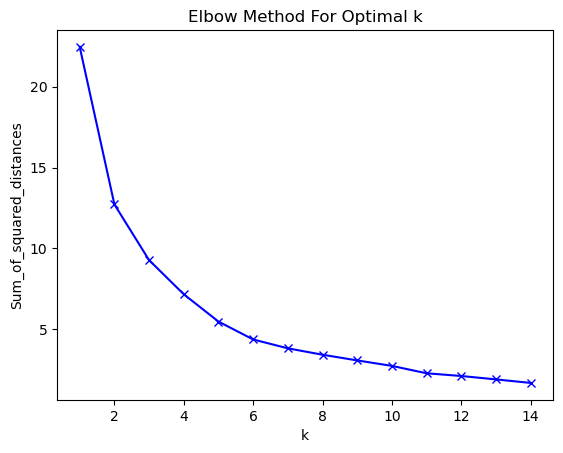

In [22]:
#Elbow method plot

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


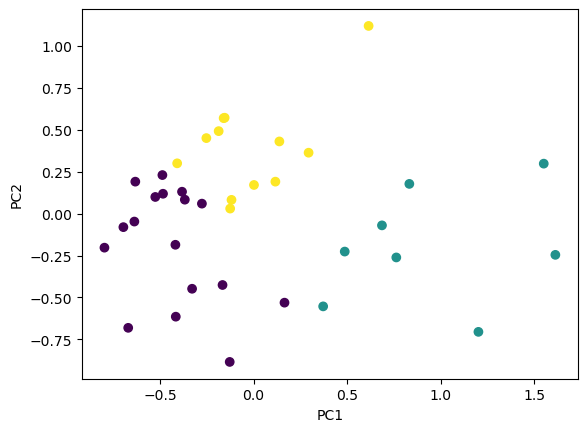

-9.277346299295093


In [23]:
# run k means with 3 cluseters and plot 
model3 = skc.KMeans(n_clusters=3)
score3 = model3.fit(weather_data_station[col_features]).score(weather_data_station[col_features])
plt.scatter(pca_2_result[:,0], pca_2_result[:,1], c=model3.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
print(score3)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


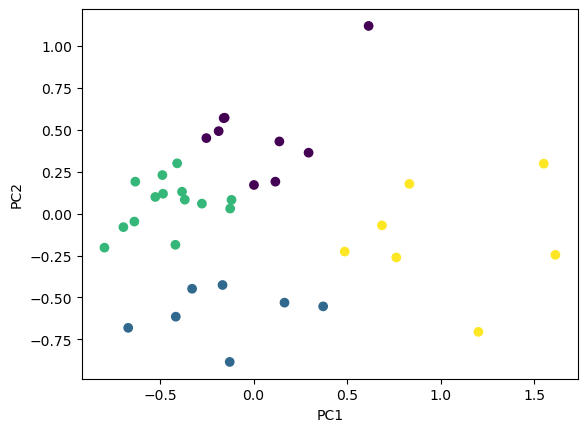

-7.152034974736851


In [24]:
# run k means with 4 cluseters and plot
model4 = skc.KMeans(n_clusters=4)
score4 = model4.fit(weather_data_station[col_features]).score(weather_data_station[col_features])
plt.scatter(pca_2_result[:,0], pca_2_result[:,1], c=model4.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
print(score4)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


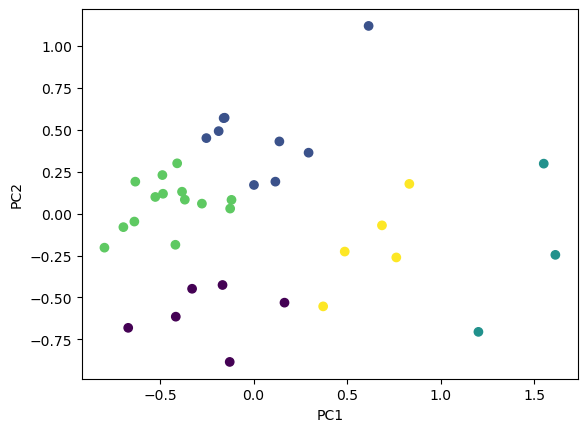

-5.481209716134847


In [25]:
#run k means with 5 cluseters and plot
model5 = skc.KMeans(n_clusters=5)
score5 = model5.fit(weather_data_station[col_features]).score(weather_data_station[col_features])
plt.scatter(pca_2_result[:,0], pca_2_result[:,1], c=model5.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
print(score5)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


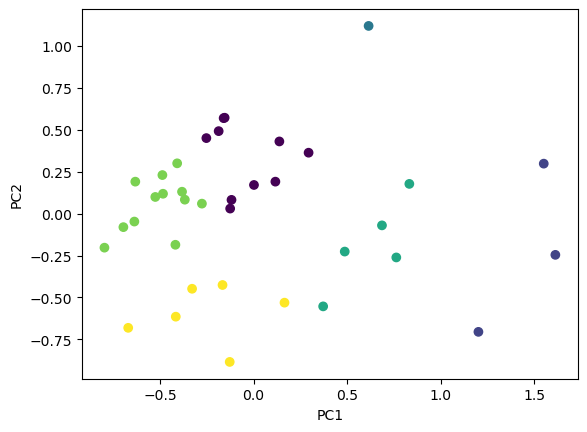

-4.373200772639084


In [26]:
# run k means with 6 cluseters and plot
model6 = skc.KMeans(n_clusters=6)
score6 = model6.fit(weather_data_station[col_features]).score(weather_data_station[col_features])
plt.scatter(pca_2_result[:,0], pca_2_result[:,1], c=model6.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
print(score6)

In [27]:
#add labels
labels = pd.DataFrame(model5.labels_)
labeled_data = pd.concat((weather_data_station,labels), axis=1)
labeled_data = labeled_data.rename({0:'labels'}, axis=1)
labeled_data

,station,yyyy,mm,tmax degC,tmin degC,af days,rain mm,sun hours,labels
0,aberporth,1982.084168,6.489980,-0.061314,0.307263,-0.393874,0.055394,0.186024,0
1,armagh,1938.083739,6.495131,0.034988,-0.091425,-0.040305,-0.096981,-0.249339,1
2,ballypatrick,1992.332447,6.510638,-0.273289,-0.125525,-0.177703,0.752743,-0.203745,4
3,bradford,1965.583931,6.492826,-0.091659,-0.058515,0.049752,-0.011232,-0.242219,1
4,braemar,1991.084399,6.487212,-0.445648,-0.563929,1.025585,0.048124,-0.350487,1
5,camborne,2000.915751,6.510989,0.141839,0.607394,-0.543959,0.345882,0.280869,0
6,cambridge,1991.084399,6.487212,0.313685,0.066817,0.016494,-0.561743,0.123717,3
7,cardiff,2000.415771,6.510753,0.387174,0.271321,-0.109378,0.515683,0.097930,0
8,chivenor,1987.823961,6.487775,0.361607,0.476571,-0.349996,0.033367,0.366489,0
9,cwmystwyth,1984.957929,6.498382,-0.231868,-0.275292,0.324225,1.573847,-0.372998,2


# Part 2: Classifying weather stations

## Preparing the data

In [28]:
stations_locations.describe()

,lat,lon
count,37.000000,37.000000
mean,53.781324,-2.721378
std,2.522246,2.156905
min,50.218000,-6.880000
25%,51.761000,-4.147000
50%,53.252000,-2.663000
75%,55.311000,-1.262000
max,60.139000,1.727000


In [29]:
# define bounds
middle_bound = stations_locations['lon'].quantile(q=0.5)
south_bound = stations_locations['lat'].quantile(q=0.33)
center_bound = stations_locations['lat'].quantile(q=0.66)

#add lat_class and lon_class to the labels
lat_class = []
for lat in stations_locations["lat"]:
    if lat >= center_bound:
        lat_class.append("North")
    elif lat < center_bound and lat >= south_bound:
        lat_class.append("Center")
    else:
        lat_class.append("South")
       
stations_locations["lat_class"] = lat_class   
stations_locations["lat_class"].value_counts()

lon_class = []

for lon in stations_locations["lon"]:
    if lon >= middle_bound:
        lon_class.append("East")
    else:
        lon_class.append("West")

stations_locations["lon_class"] = lon_class   
stations_locations["lon_class"].value_counts()

stations_locations

,station,lat,lon,lat_class,lon_class
0,aberporth,52.139,-4.570,South,West
1,armagh,54.352,-6.649,Center,West
2,ballypatrick,55.181,-6.153,North,West
3,bradford,53.813,-1.772,Center,East
4,braemar,57.006,-3.396,North,West
5,camborne,50.218,-5.327,South,West
6,cambridge,52.245,0.102,Center,East
7,cardiff,51.488,-3.187,South,West
8,chivenor,51.089,-4.147,South,West
9,cwmystwyth,52.358,-3.802,Center,West


In [30]:
#group by station and merge the two dataframes
weather_data_station2 = weather_d ata.groupby(['station']).mean().reset_index()
weather_locations_station = pd.merge(stations_locations, weather_data_station2[['station','tmax degC','tmin degC','af days', 'rain mm','sun hours']], on = 'station', how = 'right')
weather_locations_station

,station,lat,lon,lat_class,lon_class,tmax degC,tmin degC,af days,rain mm,sun hours
0,aberporth,52.139,-4.570,South,West,12.494082,7.293509,1.497519,76.238377,128.488923
1,armagh,54.352,-6.649,Center,West,12.974830,5.767226,3.277923,68.893424,104.110568
2,ballypatrick,55.181,-6.153,North,West,11.435883,5.636681,2.586053,109.852844,106.663636
3,bradford,53.813,-1.772,Center,East,12.342599,5.893213,3.731408,73.026804,104.509267
4,braemar,57.006,-3.396,North,West,10.575450,3.958355,8.645244,75.887947,98.446739
5,camborne,50.218,-5.327,South,West,13.508242,8.442491,0.741758,90.240842,133.799814
6,cambridge,52.245,0.102,Center,East,14.366113,6.373018,3.563939,46.490369,125.000000
7,cardiff,51.488,-3.187,South,West,14.732975,7.155914,2.930108,98.425806,123.556054
8,chivenor,51.089,-4.147,South,West,14.605341,7.941667,1.718468,75.176598,138.594142
9,cwmystwyth,52.358,-3.802,Center,West,11.642660,5.063333,5.113523,149.432712,97.186254


## Running the classifier

In [31]:
# Importing the dataset
X = weather_locations_station.iloc[:, 5:].values
y = weather_locations_station.iloc[:, 3].values


In [32]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 5, random_state = 0)



In [33]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [34]:
# Training the Naive Bayes model on the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [35]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)



The accuracy score is 0.6


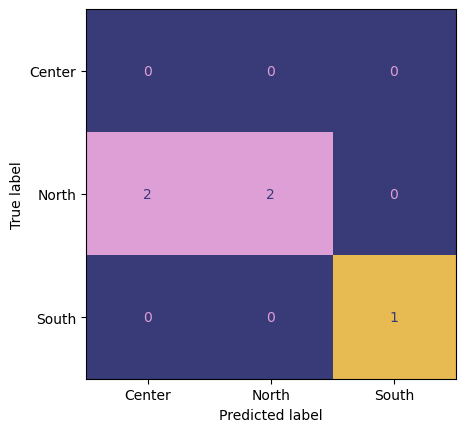

In [36]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score,ConfusionMatrixDisplay
ac = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
print('The accuracy score is', ac)
cm_disp.plot(colorbar=False, cmap = 'tab20b')
plt.show()

# Dataset 2

## Happiness data dataframe

### Importing the data

In [37]:
#import relevant columns from the csv

happiness = pd.read_csv('happiness_data.csv', skiprows = 5,sep=';', nrows = 442, usecols =[0,1,8]) 
happiness.columns = ['Area Codes', 'Area names','Avg rating',]
happiness

,Area Codes,Area names,Avg rating
0,K02000001,UNITED KINGDOM,"7,46"
1,E92000001,ENGLAND,"7,45"
2,E12000001,NORTH EAST,"7,34"
3,E06000047,NORTH EAST,"7,37"
4,E06000005,NORTH EAST,"7,46"
...,...,...,...
437,N09000008,NaN,"8,03"
438,N09000009,NaN,"7,91"
439,N09000010,NaN,"7,84"
440,N09000011,NaN,"7,32"


## Regions locations dataframe

In [38]:
#create a dataframe from the csv

regions = pd.read_csv('regions.txt', header = None) 
regions.columns = ['Area Codes', 'Area names', 'lat','lon']
regions

,Area Codes,Area names,lat,lon
0,E12000001,NORTH EAST,55.0,-1.9
1,E12000002,NORTH WEST,54.0,-2.6
2,E12000003,YORKSHIRE AND THE HUMBER,53.6,-1.2
3,E12000004,EAST MIDLANDS,53.0,-0.8
4,E12000005,WEST MIDLANDS,52.5,-2.3
5,E12000006,EAST,52.2,0.4
6,E12000007,LONDON,51.5,-0.1
7,E12000008,SOUTH EAST,51.3,-0.5
8,E12000009,SOUTH WEST,51.0,-3.2
9,W92000004,WALES,51.5,-3.2


# Part 3: Weather and happiness

## Preparing the data

### Preparing the happiness data

In [39]:
#filter the happiness data dataframe
area_codes = list(regions['Area Codes'])
happiness_filtered = happiness[happiness['Area Codes'].isin(area_codes)]
happiness_filtered

,Area Codes,Area names,Avg rating
2,E12000001,NORTH EAST,"7,34"
16,E12000002,NORTH WEST,"7,39"
60,E12000003,YORKSHIRE AND THE HUMBER,"7,41"
85,E12000004,EAST MIDLANDS,"7,51"
131,E12000005,WEST MIDLANDS,"7,43"
166,E12000006,EAST,"7,51"
219,E12000007,LONDON,"7,38"
255,E12000008,SOUTH EAST,"7,54"
330,E12000009,SOUTH WEST,"7,50"
372,W92000004,WALES,"7,44"


In [40]:
#replace commas with dots in avg rating
happiness_filtered['Avg rating'] = happiness_filtered['Avg rating'].apply(lambda x: x.replace(',', '.')).astype('float')
happiness_filtered

/tmp/ipykernel_72458/1359620977.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  happiness_filtered['Avg rating'] = happiness_filtered['Avg rating'].apply(lambda x: x.replace(',', '.')).astype('float')


,Area Codes,Area names,Avg rating
2,E12000001,NORTH EAST,7.34
16,E12000002,NORTH WEST,7.39
60,E12000003,YORKSHIRE AND THE HUMBER,7.41
85,E12000004,EAST MIDLANDS,7.51
131,E12000005,WEST MIDLANDS,7.43
166,E12000006,EAST,7.51
219,E12000007,LONDON,7.38
255,E12000008,SOUTH EAST,7.54
330,E12000009,SOUTH WEST,7.50
372,W92000004,WALES,7.44


In [41]:
#merge happiness data and regions locations
regions_happiness = regions
regions_happiness = pd.merge(regions_happiness, happiness_filtered[['Area Codes','Avg rating']], on = 'Area Codes', how = 'right')
regions_happiness

,Area Codes,Area names,lat,lon,Avg rating
0,E12000001,NORTH EAST,55.0,-1.9,7.34
1,E12000002,NORTH WEST,54.0,-2.6,7.39
2,E12000003,YORKSHIRE AND THE HUMBER,53.6,-1.2,7.41
3,E12000004,EAST MIDLANDS,53.0,-0.8,7.51
4,E12000005,WEST MIDLANDS,52.5,-2.3,7.43
5,E12000006,EAST,52.2,0.4,7.51
6,E12000007,LONDON,51.5,-0.1,7.38
7,E12000008,SOUTH EAST,51.3,-0.5,7.54
8,E12000009,SOUTH WEST,51.0,-3.2,7.50
9,W92000004,WALES,51.5,-3.2,7.44


In [42]:
#add the latitude and longitude classification 
lat_class2 = []
for lat in regions_happiness["lat"]:
    if lat >= center_bound:
        lat_class2.append("North")
    elif lat < center_bound and lat >= south_bound:
        lat_class2.append("Center")
    else:
        lat_class2.append("South")
       
regions_happiness["lat_class"] = lat_class2   
regions_happiness["lat_class"].value_counts()

lon_class2 = []

for lon in regions_happiness["lon"]:
    if lon >= middle_bound:
        lon_class2.append("East")
    else:
        lon_class2.append("West")

regions_happiness["lon_class"] = lon_class2   
regions_happiness["lon_class"].value_counts()
regions_happiness["area"] = regions_happiness["lat_class"] + " " + regions_happiness["lon_class"]

regions_happiness

,Area Codes,Area names,lat,lon,Avg rating,lat_class,lon_class,area
0,E12000001,NORTH EAST,55.0,-1.9,7.34,North,East,North East
1,E12000002,NORTH WEST,54.0,-2.6,7.39,Center,East,Center East
2,E12000003,YORKSHIRE AND THE HUMBER,53.6,-1.2,7.41,Center,East,Center East
3,E12000004,EAST MIDLANDS,53.0,-0.8,7.51,Center,East,Center East
4,E12000005,WEST MIDLANDS,52.5,-2.3,7.43,Center,East,Center East
5,E12000006,EAST,52.2,0.4,7.51,South,East,South East
6,E12000007,LONDON,51.5,-0.1,7.38,South,East,South East
7,E12000008,SOUTH EAST,51.3,-0.5,7.54,South,East,South East
8,E12000009,SOUTH WEST,51.0,-3.2,7.50,South,West,South West
9,W92000004,WALES,51.5,-3.2,7.44,South,West,South West


In [43]:
#descriptives of avg rating
regions_happiness['Avg rating'].describe()

count    12.000000
mean      7.470833
std       0.106725
min       7.340000
25%       7.405000
50%       7.445000
75%       7.510000
max       7.750000
Name: Avg rating, dtype: float64

### Preparing weather data

In [44]:
weather_locations_station.dtypes

station       object
lat          float64
lon          float64
lat_class     object
lon_class     object
tmax degC    float64
tmin degC    float64
af days      float64
rain mm      float64
sun hours    float64
dtype: object

In [45]:
#group the weather data by latand lon and create an area column
weather_area = weather_locations_station.groupby(['lat_class', 'lon_class'])[col_features].mean().reset_index()

weather_area['area'] = weather_area["lat_class"] + " " + weather_area["lon_class"]
weather_area

,lat_class,lon_class,tmax degC,tmin degC,af days,rain mm,sun hours,area
0,Center,East,13.220135,6.194188,3.486656,57.041804,120.202433,Center East
1,Center,West,12.556857,6.129192,3.321724,96.554270,111.450193,Center West
2,North,East,10.970281,5.096820,3.934631,75.799104,100.273633,North East
3,North,West,11.636427,5.380313,4.160361,92.374359,106.763500,North West
4,South,East,14.311115,6.851930,3.307464,59.975865,135.971275,South East
5,South,West,13.835160,7.708395,1.721963,85.020406,131.109733,South West


In [46]:
#merge weather and happiness by region on area
happiness_weather = pd.merge(regions_happiness, weather_area[['area','tmax degC','tmin degC', 'af days', 'rain mm', 'sun hours']], on = 'area', how = 'left')
happiness_weather

,Area Codes,Area names,lat,lon,Avg rating,lat_class,lon_class,area,tmax degC,tmin degC,af days,rain mm,sun hours
0,E12000001,NORTH EAST,55.0,-1.9,7.34,North,East,North East,10.970281,5.096820,3.934631,75.799104,100.273633
1,E12000002,NORTH WEST,54.0,-2.6,7.39,Center,East,Center East,13.220135,6.194188,3.486656,57.041804,120.202433
2,E12000003,YORKSHIRE AND THE HUMBER,53.6,-1.2,7.41,Center,East,Center East,13.220135,6.194188,3.486656,57.041804,120.202433
3,E12000004,EAST MIDLANDS,53.0,-0.8,7.51,Center,East,Center East,13.220135,6.194188,3.486656,57.041804,120.202433
4,E12000005,WEST MIDLANDS,52.5,-2.3,7.43,Center,East,Center East,13.220135,6.194188,3.486656,57.041804,120.202433
5,E12000006,EAST,52.2,0.4,7.51,South,East,South East,14.311115,6.851930,3.307464,59.975865,135.971275
6,E12000007,LONDON,51.5,-0.1,7.38,South,East,South East,14.311115,6.851930,3.307464,59.975865,135.971275
7,E12000008,SOUTH EAST,51.3,-0.5,7.54,South,East,South East,14.311115,6.851930,3.307464,59.975865,135.971275
8,E12000009,SOUTH WEST,51.0,-3.2,7.50,South,West,South West,13.835160,7.708395,1.721963,85.020406,131.109733
9,W92000004,WALES,51.5,-3.2,7.44,South,West,South West,13.835160,7.708395,1.721963,85.020406,131.109733


## Looking at correlations

In [47]:
correlations = happiness_weather.loc[:,['Avg rating','tmax degC','tmin degC', 'af days', 'rain mm', 'sun hours']].corr()
correlations

,Avg rating,tmax degC,tmin degC,af days,rain mm,sun hours
Avg rating,1.000000,0.283363,0.181602,-0.082272,-0.200503,0.232928
tmax degC,0.283363,1.000000,0.836936,-0.541879,-0.393149,0.983130
tmin degC,0.181602,0.836936,1.000000,-0.906484,0.089325,0.872271
af days,-0.082272,-0.541879,-0.906484,1.000000,-0.346923,-0.588795
rain mm,-0.200503,-0.393149,0.089325,-0.346923,1.000000,-0.264932
sun hours,0.232928,0.983130,0.872271,-0.588795,-0.264932,1.000000


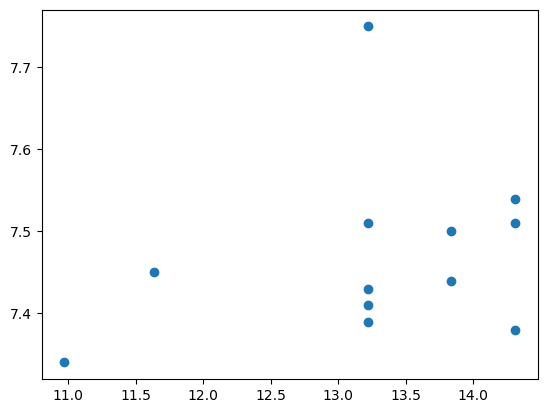

In [48]:
#plot the most correlated variable
plt.scatter(happiness_weather['tmax degC'], happiness_weather['Avg rating'])


# Part 4: The seasonality of weather data

In [49]:
weather_data_means

,station,yyyy,mm,tmax degC,tmin degC,af days,rain mm,sun hours
0,aberporth,1941,1,-0.061314,0.307263,-0.393874,0.023479,0.186024
1,aberporth,1941,2,-0.061314,0.307263,-0.393874,-0.092695,0.186024
2,aberporth,1941,3,-0.061314,0.307263,-0.393874,0.054598,0.186024
3,aberporth,1941,4,-0.061314,0.307263,-0.393874,-0.827086,0.186024
4,aberporth,1941,5,-0.061314,0.307263,-0.393874,-0.461965,0.186024
...,...,...,...,...,...,...,...,...
39258,yeovilton,2023,10,0.881361,0.805266,-0.691264,0.905163,-0.294175
39259,yeovilton,2023,11,-0.180319,-0.239593,0.103091,0.398973,-0.899581
39260,yeovilton,2023,12,-0.300509,-0.108985,0.301680,1.274433,-1.776439
39261,yeovilton,2024,1,-0.861396,-1.232209,1.294625,-0.239988,-0.728139


In [50]:
winter = [12,1,2]
spring = [3,4,5]
summer = [6,7,8]
fall = [9,10,11]

#for month in month: 
winter_weather = weather_data_means[weather_data_means['mm'].isin(winter)].groupby('station').mean().reset_index()
spring_weather = weather_data_means[weather_data_means['mm'].isin(spring)].groupby('station').mean().reset_index()
summer_weather = weather_data_means[weather_data_means['mm'].isin(summer)].groupby('station').mean().reset_index()
fall_weather = weather_data_means[weather_data_means['mm'].isin(fall)].groupby('station').mean().reset_index()




## Looking at the whole dataset

Explained variation explained by each component: [0.51471721 0.37149131]
Cumulative variance explained by components: 88.62%


       tmax degC  tmin degC   af days   rain mm  sun hours
PC_1   0.015995   0.099618  0.287691  0.949825   0.069904
PC_2   0.271999   0.280973  0.853048  0.277253   0.206181


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


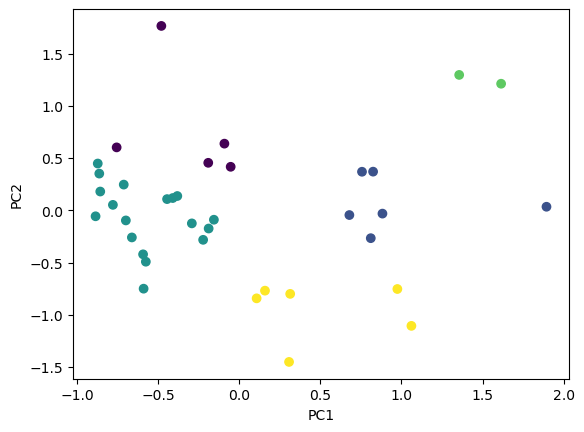

In [51]:
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(winter_weather[col_features])
print('Explained variation explained by each component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=winter_weather[col_features].columns, index=['PC_1', 'PC_2'])
print('\n\n', dataset_pca)


model = skc.KMeans(n_clusters=5)
model.fit(winter_weather[col_features]).score(winter_weather[col_features])

plt.scatter(pca_2_result[:,0], pca_2_result[:,1], c=model.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


labels = pd.DataFrame(model.labels_)
labeled_data = pd.concat((winter_weather,labels), axis=1)
labeled_data = labeled_data.rename({0:'winter_labels'}, axis=1)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Explained variation explained by each component: [0.57118415 0.24319511]
Cumulative variance explained by components: 81.44%


       tmax degC  tmin degC   af days   rain mm  sun hours
PC_1   0.292220   0.428759  0.562319  0.430830   0.478493
PC_2   0.086303   0.281286  0.494274  0.816772   0.044796


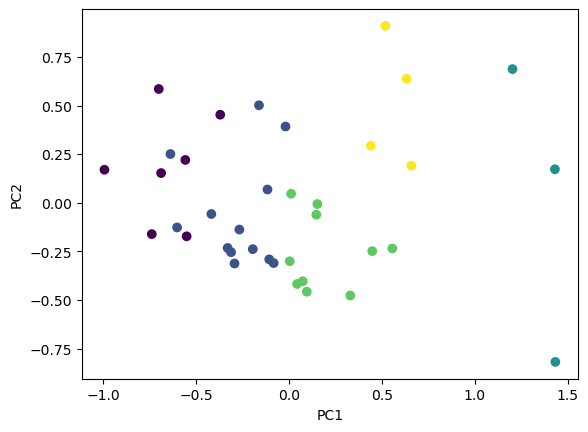

In [52]:
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(spring_weather[col_features])
print('Explained variation explained by each component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=spring_weather[col_features].columns, index=['PC_1', 'PC_2'])
print('\n\n', dataset_pca)


model = skc.KMeans(n_clusters=5)
model.fit(spring_weather[col_features]).score(spring_weather[col_features])

plt.scatter(pca_2_result[:,0], pca_2_result[:,1], c=model.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


labels = pd.DataFrame(model.labels_)
labeled_data['spring_labels'] = labels

Explained variation explained by each component: [0.71336321 0.12519197]
Cumulative variance explained by components: 83.86%


       tmax degC  tmin degC   af days   rain mm  sun hours
PC_1   0.451478   0.419061  0.046202  0.413729   0.668767
PC_2   0.809324   0.029688  0.031613  0.028920   0.585044


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


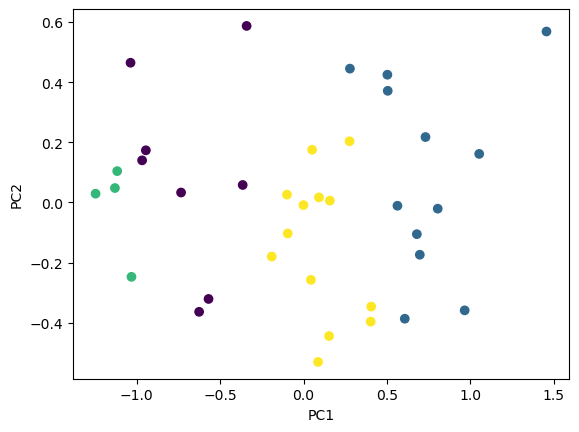

In [53]:
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(summer_weather[col_features])
print('Explained variation explained by each component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=summer_weather[col_features].columns, index=['PC_1', 'PC_2'])
print('\n\n', dataset_pca)


model = skc.KMeans(n_clusters=4)
model.fit(summer_weather[col_features]).score(summer_weather[col_features])

plt.scatter(pca_2_result[:,0], pca_2_result[:,1], c=model.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


labels = pd.DataFrame(model.labels_)
labeled_data['summer_labels'] = labels


Explained variation explained by each component: [0.65939989 0.25429637]
Cumulative variance explained by components: 91.37%


       tmax degC  tmin degC   af days   rain mm  sun hours
PC_1   0.235935   0.150453  0.077273  0.926898   0.237882
PC_2   0.363524   0.674065  0.447964  0.323657   0.328727


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


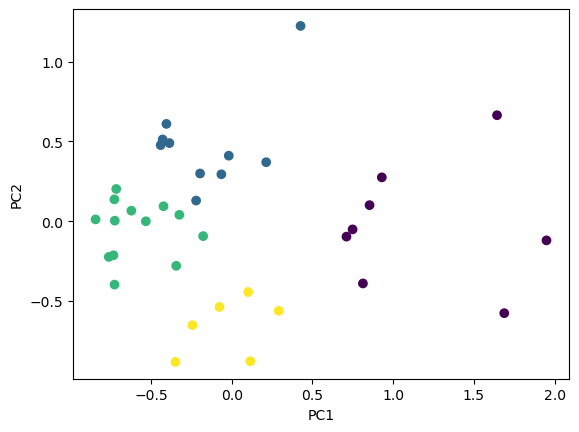

In [54]:
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(fall_weather[col_features])
print('Explained variation explained by each component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=fall_weather[col_features].columns, index=['PC_1', 'PC_2'])
print('\n\n', dataset_pca)


model = skc.KMeans(n_clusters=4)
model.fit(fall_weather[col_features]).score(fall_weather[col_features])

plt.scatter(pca_2_result[:,0], pca_2_result[:,1], c=model.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


labels = pd.DataFrame(model.labels_)
labeled_data['fall_labels'] = labels


In [55]:
labeled_data

,station,yyyy,mm,tmax degC,tmin degC,af days,rain mm,sun hours,winter_labels,spring_labels,summer_labels,fall_labels
0,aberporth,1982.334661,4.972112,-1.010655,-0.698040,0.117238,0.264053,-1.017600,4,0,1,3
1,armagh,1938.333981,4.986408,-0.978302,-0.970104,0.804346,-0.046846,-0.773640,2,3,0,1
2,ballypatrick,1992.666667,5.000000,-1.140150,-0.965184,0.479758,0.954901,-0.639253,1,4,2,0
3,bradford,1965.834286,4.980000,-1.282928,-1.115568,1.237013,0.237919,-1.390902,0,3,3,1
4,braemar,1991.335025,4.964467,-1.647004,-1.060762,2.766401,0.268953,-1.154777,0,2,0,1
5,camborne,2001.166667,5.000000,-0.703465,-0.318714,-0.212061,0.911312,-0.946635,4,0,1,3
6,cambridge,1991.335025,4.964467,-1.063950,-1.052673,1.191802,-0.620048,-0.808729,2,1,1,2
7,cardiff,2000.666667,5.000000,-0.811530,-0.877068,0.932658,0.956733,-0.390699,1,1,3,3
8,chivenor,1988.087379,4.966019,-0.324645,-0.195666,-0.009033,0.227630,-0.019920,4,1,3,3
9,cwmystwyth,1985.575163,5.000000,-1.245891,-1.152046,1.572979,2.100998,-1.350155,3,2,2,0


In [56]:
clusters = labeled_data.groupby(['winter_labels','spring_labels','summer_labels','fall_labels']).count().reset_index()
clusters

,winter_labels,spring_labels,summer_labels,fall_labels,station,yyyy,mm,tmax degC,tmin degC,af days,rain mm,sun hours
0,0,1,1,2,1,1,1,1,1,1,1,1
1,0,2,0,1,1,1,1,1,1,1,1,1
2,0,3,0,1,1,1,1,1,1,1,1,1
3,0,3,3,1,2,2,2,2,2,2,2,2
4,1,1,3,0,1,1,1,1,1,1,1,1
5,1,1,3,3,1,1,1,1,1,1,1,1
6,1,4,0,0,2,2,2,2,2,2,2,2
7,1,4,2,0,2,2,2,2,2,2,2,2
8,2,0,1,2,2,2,2,2,2,2,2,2
9,2,1,1,2,5,5,5,5,5,5,5,5


## Looking at the 2017-2021 period

In [57]:
years = [2021,2020,2019,2018,2017]

weather_data_recent = weather_data_means[weather_data_means['yyyy'].isin(years)]

winter_weather = weather_data_recent[weather_data_means['mm'].isin(winter)].groupby('station').mean().reset_index()
spring_weather = weather_data_recent[weather_data_means['mm'].isin(spring)].groupby('station').mean().reset_index()
summer_weather = weather_data_recent[weather_data_means['mm'].isin(summer)].groupby('station').mean().reset_index()
fall_weather = weather_data_recent[weather_data_means['mm'].isin(fall)].groupby('station').mean().reset_index()

#mask = df[['A','B']].isin({'A': [1, 3], 'B': [4, 7, 12]}).all(axis=1)


/tmp/ipykernel_72458/933440381.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  winter_weather = weather_data_recent[weather_data_means['mm'].isin(winter)].groupby('station').mean().reset_index()
/tmp/ipykernel_72458/933440381.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spring_weather = weather_data_recent[weather_data_means['mm'].isin(spring)].groupby('station').mean().reset_index()
/tmp/ipykernel_72458/933440381.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  summer_weather = weather_data_recent[weather_data_means['mm'].isin(summer)].groupby('station').mean().reset_index()
/tmp/ipykernel_72458/933440381.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fall_weather = weather_data_recent[weather_data_means['mm'].isin(fall)].groupby('station').mean().reset_index()


Explained variation explained by each component: [0.45577542 0.33430148]
Cumulative variance explained by components: 79.01%


       tmax degC  tmin degC   af days   rain mm  sun hours
PC_1   0.086908   0.236736  0.667893  0.675681   0.183788
PC_2   0.190722   0.199638  0.634859  0.721610   0.001504


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


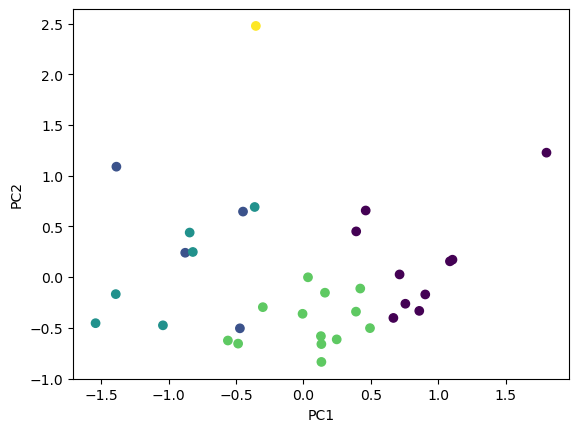

In [58]:
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(winter_weather[col_features])
print('Explained variation explained by each component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=winter_weather[col_features].columns, index=['PC_1', 'PC_2'])
print('\n\n', dataset_pca)


model = skc.KMeans(n_clusters=5)
model.fit(winter_weather[col_features]).score(winter_weather[col_features])

plt.scatter(pca_2_result[:,0], pca_2_result[:,1], c=model.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


labels = pd.DataFrame(model.labels_)
labeled_data2 = pd.concat((winter_weather,labels), axis=1)
labeled_data2 = labeled_data.rename({0:'winter_labels'}, axis=1)

Explained variation explained by each component: [0.57278295 0.19314141]
Cumulative variance explained by components: 76.59%


       tmax degC  tmin degC   af days   rain mm  sun hours
PC_1   0.221280   0.361542  0.544402  0.281065   0.667047
PC_2   0.077118   0.312847  0.659132  0.482220   0.478737


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


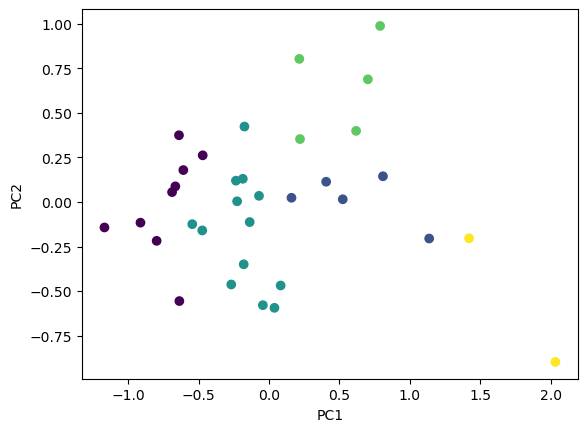

In [59]:
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(spring_weather[col_features])
print('Explained variation explained by each component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=spring_weather[col_features].columns, index=['PC_1', 'PC_2'])
print('\n\n', dataset_pca)


model = skc.KMeans(n_clusters=5)
model.fit(spring_weather[col_features]).score(spring_weather[col_features])

plt.scatter(pca_2_result[:,0], pca_2_result[:,1], c=model.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


labels = pd.DataFrame(model.labels_)
labeled_data2['spring_labels'] = labels

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Explained variation explained by each component: [0.70879592 0.14655089]
Cumulative variance explained by components: 85.53%


       tmax degC  tmin degC   af days   rain mm  sun hours
PC_1   0.382447   0.353209  0.003530  0.369388   0.769752
PC_2   0.760078   0.229762  0.001346  0.193886   0.576105


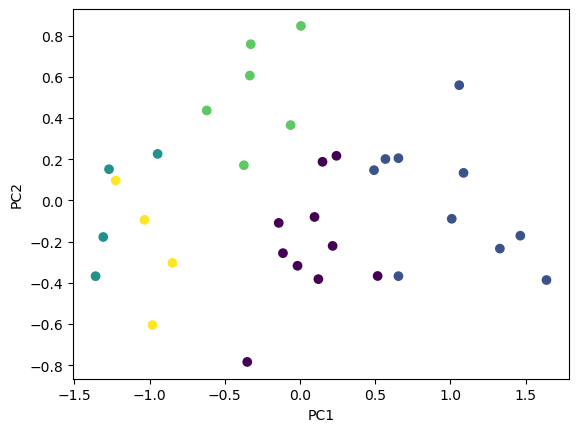

In [60]:
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(summer_weather[col_features])
print('Explained variation explained by each component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=summer_weather[col_features].columns, index=['PC_1', 'PC_2'])
print('\n\n', dataset_pca)


model = skc.KMeans(n_clusters=5)
model.fit(summer_weather[col_features]).score(summer_weather[col_features])

plt.scatter(pca_2_result[:,0], pca_2_result[:,1], c=model.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


labels = pd.DataFrame(model.labels_)
labeled_data2['summer_labels'] = labels

Explained variation explained by each component: [0.67207592 0.20786776]
Cumulative variance explained by components: 87.99%


       tmax degC  tmin degC   af days   rain mm  sun hours
PC_1   0.264678   0.135561  0.067740  0.918862   0.250344
PC_2   0.327996   0.723633  0.509459  0.284580   0.168048


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


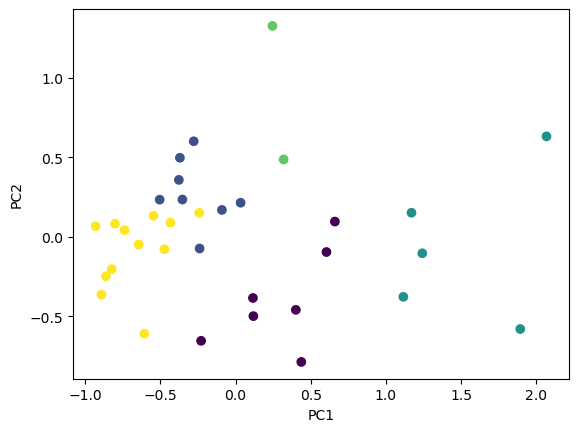

In [61]:
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(fall_weather[col_features])
print('Explained variation explained by each component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=fall_weather[col_features].columns, index=['PC_1', 'PC_2'])
print('\n\n', dataset_pca)


model = skc.KMeans(n_clusters=5)
model.fit(fall_weather[col_features]).score(fall_weather[col_features])

plt.scatter(pca_2_result[:,0], pca_2_result[:,1], c=model.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


labels = pd.DataFrame(model.labels_)
labeled_data2['fall_labels'] = labels


In [62]:
labeled_data2

,station,yyyy,mm,tmax degC,tmin degC,af days,rain mm,sun hours,winter_labels,spring_labels,summer_labels,fall_labels
0,aberporth,1982.334661,4.972112,-1.010655,-0.698040,0.117238,0.264053,-1.017600,4,0.0,0.0,0.0
1,armagh,1938.333981,4.986408,-0.978302,-0.970104,0.804346,-0.046846,-0.773640,2,2.0,3.0,1.0
2,ballypatrick,1992.666667,5.000000,-1.140150,-0.965184,0.479758,0.954901,-0.639253,1,3.0,2.0,0.0
3,bradford,1965.834286,4.980000,-1.282928,-1.115568,1.237013,0.237919,-1.390902,0,2.0,0.0,1.0
4,braemar,1991.335025,4.964467,-1.647004,-1.060762,2.766401,0.268953,-1.154777,0,4.0,4.0,3.0
5,camborne,2001.166667,5.000000,-0.703465,-0.318714,-0.212061,0.911312,-0.946635,4,0.0,0.0,0.0
6,cambridge,1991.335025,4.964467,-1.063950,-1.052673,1.191802,-0.620048,-0.808729,2,1.0,3.0,4.0
7,cardiff,2000.666667,5.000000,-0.811530,-0.877068,0.932658,0.956733,-0.390699,1,3.0,3.0,0.0
8,chivenor,1988.087379,4.966019,-0.324645,-0.195666,-0.009033,0.227630,-0.019920,4,2.0,3.0,0.0
9,cwmystwyth,1985.575163,5.000000,-1.245891,-1.152046,1.572979,2.100998,-1.350155,3,3.0,2.0,2.0


In [63]:
clusters2 = labeled_data2.groupby(['winter_labels','spring_labels','summer_labels','fall_labels']).count().reset_index()
clusters2

,winter_labels,spring_labels,summer_labels,fall_labels,station,yyyy,mm,tmax degC,tmin degC,af days,rain mm,sun hours
0,0,0.0,1.0,4.0,1,1,1,1,1,1,1,1
1,0,2.0,0.0,1.0,1,1,1,1,1,1,1,1
2,0,2.0,1.0,4.0,1,1,1,1,1,1,1,1
3,0,3.0,4.0,2.0,1,1,1,1,1,1,1,1
4,0,4.0,4.0,3.0,1,1,1,1,1,1,1,1
5,1,0.0,0.0,0.0,1,1,1,1,1,1,1,1
6,1,1.0,3.0,1.0,1,1,1,1,1,1,1,1
7,1,2.0,0.0,1.0,1,1,1,1,1,1,1,1
8,1,2.0,1.0,4.0,1,1,1,1,1,1,1,1
9,1,3.0,2.0,0.0,1,1,1,1,1,1,1,1
